### Importación de librerías necesarias y conexión con microservicio de almacenamiento

In [2]:
import pandas as pd
import time
import gspread
from google.oauth2.service_account import Credentials
from gspread_dataframe import get_as_dataframe, set_with_dataframe
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import numpy as np
from sklearn.impute import KNNImputer
plt.style.use('ggplot')

In [3]:
scope = ['https://www.googleapis.com/auth/spreadsheets',
        'https://www.googleapis.com/auth/drive']

creds = Credentials.from_service_account_file("/work/cuenta de servicio.json", scopes=scope)
client = gspread.authorize(creds)

In [4]:
worksheet_data = client.open("SP_500_data").get_worksheet(0).get_all_records()
worksheet = client.open("SP_500_data").get_worksheet(0)

In [ ]:
# si desea realizar el trabajo en local solo debe reemplazar get as dataframe por read_csv 
# apuntando a la base de datos que puede descargar mediante el link
data = get_as_dataframe(worksheet)
data.set_index("Date", inplace=True)

En este apartado se realiza la configuración de toda la lógica para establecer un microservicio de almacenamiento de datos que alberga la información de los precios de cierre de los 503 simbolos del índice SP&500 y los actualiza todos los días a las 7:00 PM. De esta forma se asegura tener un insumo que puede ser llamado desde diversas plataformas de inteligencia de negocio y desde python para el análisis y procesamiento al que haya a lugar.

Adiconalemente a esto a continuación se deja una relación de los origénes de datos y de las herramientas necesarias para implememtación de este workflow

* yfinance librería de python, puede encontrarla en el siguiente link (https://pypi.org/project/yfinance/)
* Cuenta de Google 
* Configuración de una cuenta de servicios en GCP y habilitación de las API's de GDrive y Spreadsheets
* Lenguaje computacional python

Podra obtener acceso a la base de datos en cualquier momento mediante el siguiente enlace 
https://docs.google.com/spreadsheets/d/e/2PACX-1vQJhwKp9kXl0ta8NsK9oKwNOPw8pBNldvR2_am8SOuJidAuywapixZ03kL__IqAOZZUsX1ctCGd1lfp/pub?output=csv

# Análisis exploratorio de datos

### Anáilisis de completitud y validez de la información por filas y columnas

In [87]:
print(f"Cantidad de columnas ('Simbolos')  {data.shape[1]}")
print(f"Cantidad de filas ('observaciones')  {data.shape[0]}")
print(f"Fecha desde {min(data.index)}")
print(f"Fecha hasta {max(data.index)}")

Cantidad de columnas ('Simbolos')  501
Cantidad de filas ('observaciones')  227
Fecha desde 2022-01-03 00:00:00
Fecha hasta 2022-11-18 00:00:00


In [6]:
n = {i:data[i].isnull().sum() for i in data.columns if data[i].isnull().sum()>0}
d = {i:data[i].isnull().sum() for i in data.columns if data[i].isnull().sum()==0}
nulls = pd.DataFrame.from_dict(n, orient="index")
nulls.reset_index(inplace=True)
nulls.columns = ["Simbolo","Valores_nulos"]
no_nulls = pd.DataFrame.from_dict(d, orient="index")
no_nulls.reset_index(inplace=True)
no_nulls.columns = ["Simbolo","Valores_nulos"]
completitud = pd.concat([nulls,no_nulls]).reset_index(drop=True)


In [7]:
conditions = [
    (completitud['Valores_nulos'] > len(data)/2),
    (completitud['Valores_nulos'] < len(data)/2) & (completitud['Valores_nulos'] >= 1),
    (completitud['Valores_nulos'] == 0),
        
    ]
values = ['Candidata a eliminar', 'Candidata a imputar', 'Datos completos']

completitud["Categoria"] = np.select(conditions,values)



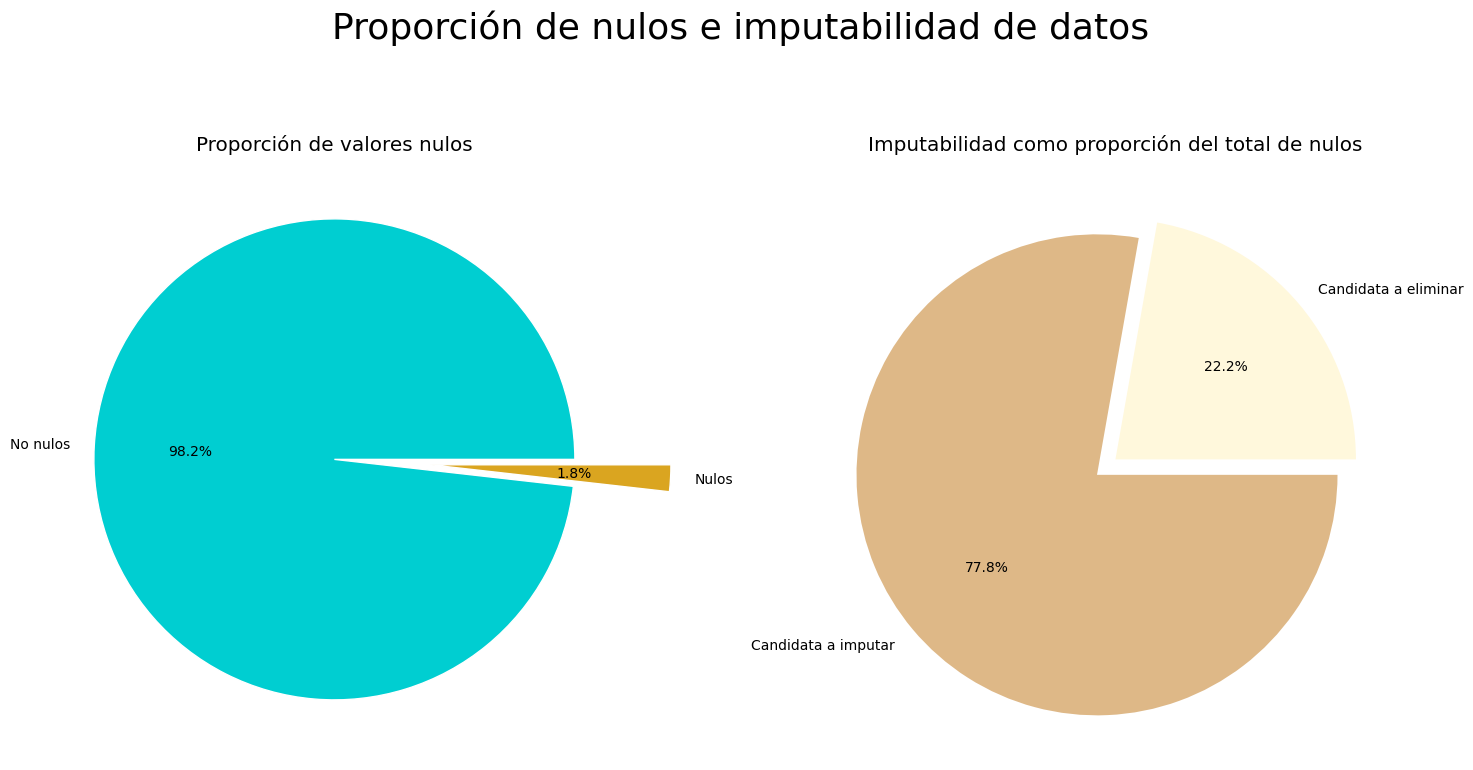

In [8]:
fig, ax = plt.subplots(1,2, figsize=(15,15))

ax[0].pie(x = ((completitud.Valores_nulos>0)*1).value_counts(),
        labels=["No nulos","Nulos"], autopct='%1.1f%%',
        explode= (0,0.4),
        wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' },
        colors = ["#00CED1","#DAA520"]
        )
ax[0].title.set_text("Proporción de valores nulos")
ax[1].pie(x=completitud[completitud.Categoria!="Datos completos"].groupby("Categoria").count()["Simbolo"],
          labels=['Candidata a eliminar','Candidata a imputar'],
          colors= ["#FFF8DC","#DEB887",],
          explode= (0,0.1),
          autopct='%1.1f%%'
          )
ax[1].title.set_text("Imputabilidad como proporción del total de nulos")
fig.suptitle('Proporción de nulos e imputabilidad de datos', x= 0.5, y=0.8, fontsize=26)
# plt.title('Proporción de nulos e imputabilidad de datos')
fig.tight_layout()
fig.subplots_adjust(top=0.99)


En este ejercico se realiza el calculo de cpmletitud y validez de la información y se presenta de forma gráfica, lo primero que se realiza es :

* Cálculo de valores nulos
* Cálculo de valores no nulos
* Propensión a imputabilidad
* Etiquetado de datos 

Una vez realizadocáculo se puede observar que el 1.8% del total de los datos corresponde a valores nulos y que de ese porcentaje el 77.8% son candidatos a ser imputados, dentro de las diversas técnicas de imputación de datos se observo que el algoritmo de KNN cobfigurado con dos vecinos resulta la herramiento más simple y eficiente para realizar este cáculo como lo veremos más adelante.

In [9]:
fig = go.Figure(go.Indicator(
    mode = "gauge+number+delta",
    value = round((len([j for i,j in enumerate(completitud.Simbolo) if completitud.Valores_nulos.iloc[i]< len(data)/2])/503)*100,2),
    domain = {'x': [0, 1], 'y': [0, 1]},
    delta = {'reference': 90, 'increasing': {'color': "RebeccaPurple"}},
    gauge = {'axis': {'range': [None, 100]},
             'bar': {'color': "darkblue"},
             'bgcolor': "white",
             'borderwidth': 2,
             'bordercolor': "gray",
             'steps': [
                        {'range': [0, 90], 'color': 'cyan'},
                        {'range': [90, 100], 'color': 'royalblue'}]
            },
    title = {'text': "Completitud por cantidad de simbolos como procentaje"}))

fig.update_layout(font = {'color': "darkblue", 'family': "Arial"})

fig.show()

En este paso se realiza el analísis de completitud de información para los simbolos, en donde se pretende identificar, la cantidad de simbolos importados con información y que no sean canditaos a ser eliminados. De esta forma encontramos que los simbolos **BRK.B (Berkshire Hathaway Inc Class B)** y **BF.B (Brown-Forman Corporation Class B)** no continene ningún dato.

Luego de realizar este cálculo se procede a realizar uná métrica para la completitud en donde se establece un umbral mínimo de aceptación de antidad de variables perdidas del 90% y se representan los resultados mediante un gauge chart obteniendo como resultado una completitud del 99.6% situandose 9.6 puntos por encima del umbral definido.


In [10]:
fig = go.Figure(go.Indicator(
    mode = "gauge+number+delta",
    value = round((data._get_numeric_data().count().sum())/(len(data)*503)*100,2),
    domain = {'x': [0, 1], 'y': [0, 1]},
    delta = {'reference': 90, 'increasing': {'color': "RebeccaPurple"}},
    gauge = {'axis': {'range': [None, 100]},
             'bar': {'color': "darkblue"},
             'bgcolor': "white",
             'borderwidth': 2,
             'bordercolor': "gray",
             'steps': [
                        {'range': [0, 90], 'color': 'cyan'},
                        {'range': [90, 100], 'color': 'royalblue'}]
            },
    title = {'text': "Validez de la data como porcentaje como procentaje"}))

fig.update_layout(font = {'color': "darkblue", 'family': "Arial"})

fig.show()

En este punto se realiza el cálculo de la validez de la data, para llevarlo a cabo, se identifican todos los valores numéricos y no numéricos de la base para posteriormente realizar el cálculo de la proporción de aquellos valores.

Del anterior ejercicio se obtuvo que el 99.5% de los datos corresponden a datos válidos, pudiendose mejorar este resultado mediante la imputación de variables. 

### Eliminando simbolos

In [11]:
descartar = [j for i,j in enumerate(completitud.Simbolo) if completitud.Categoria.iloc[i]=="Candidata a eliminar"]
seleccionar = [i for i in data.columns if i not in descartar]
data = data[seleccionar]

## imputando datos con KNN y los dos valores más cercanos

In [12]:
imputer = KNNImputer(n_neighbors=2, weights="uniform")
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns, index= data.index)

In [17]:
fig = go.Figure(go.Indicator(
    mode = "gauge+number+delta",
    value = round((data._get_numeric_data().count().sum())/(len(data)*len(data.columns))*100,2),
    domain = {'x': [0, 1], 'y': [0, 1]},
    delta = {'reference': 90, 'increasing': {'color': "RebeccaPurple"}},
    gauge = {'axis': {'range': [None, 100]},
             'bar': {'color': "darkblue"},
             'bgcolor': "white",
             'borderwidth': 2,
             'bordercolor': "gray",
             'steps': [
                        {'range': [0, 90], 'color': 'cyan'},
                        {'range': [90, 100], 'color': 'royalblue'}]
            },
    title = {'text': "Validez de la data como porcentaje como procentaje"}))

fig.update_layout(font = {'color': "darkblue", 'family': "Arial"})

fig.show()

Luego de reralizar la impuitación se puede observar que no se evidencia la existencia de información no valida y por ende no hay presencia de valores nulos al obtener un porcentaje de validez del 100%.

Ahora bien en este apartado se aplicó la técnica de KNN imputer, configurada con dos vecinos para realizar la imputación de valores nulos, la lógica detrpas de esta decisión se explica a continuación.

Al existir un valor nulo, se podría realizar la imputación con el valor medio de toda la serie a la que pertenece, pero eso no sería el cáculo más adecuado pára trabajar con variables de tipo financiero, es por esto que para simplicar el calculo, ante la presencia de un valor nulo se busca el valor previo y el valor posterior a ese dato nulo y se realiza el promedio de esos dos valores:

<p><center>null_imputed = (previos_value + next_value)/2<center><p>

De esta forma, este cálculo permitira realizar una imputación lo más cercana posible a la tendencia presenciada para ese corto periodo de tiempo.

### Transformaciones a los datos

In [61]:
data_pct = data.pct_change().dropna()
data_pct.index = pd.to_datetime(data_pct.index)
data.index = pd.to_datetime(data.index)

Para aboradar en adelante la propuesta de proyecto, se obtendrán las variaciones porcentuales de los precios de los activos, esto se realiza medfiante la función pct_change

<AxesSubplot: >

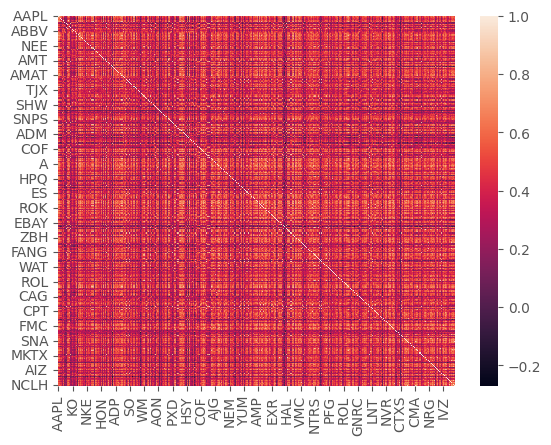

In [33]:
sns.heatmap(data_pct.corr())

Al tratarse de 503 variables inteantar aplicar un enfoque directo para observar la correlación de la variacón de los precios de los simbolos no tiene mucho sentido, en adelante se probaran dos enfoques, uno trabjar la correlación con respecto a la variable fecha y dos, realizar el analisis basado en el subconjunto de simbolos en el que el grupo Stanley posee inversiones actualmente o una mezcla de ambas.

Text(0.5, 1.1, 'Variación % mensual de los precios para el subconjunto de simbolos del SP&500')

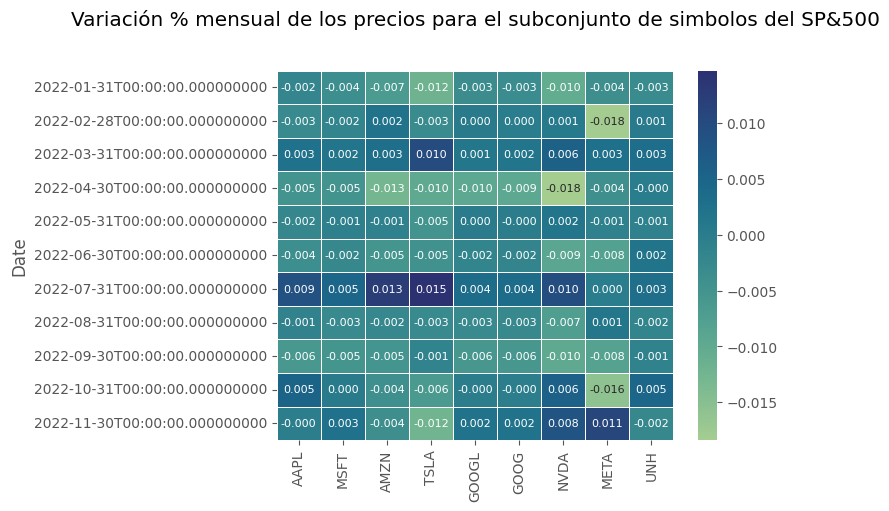

In [44]:
subconjunto = ["AAPL","MSFT","AMZN","TSLA","GOOGL","GOOG","NVDA","META","UNH"]
sns.heatmap(data_pct[subconjunto].resample("M").mean(), annot=True, fmt=".3f",
            linewidth=.5, 
            cmap="crest",
            annot_kws={"fontsize":8}
            )
plt.title("Variación % mensual de los precios para el subconjunto de simbolos del SP&500", y=1.1)

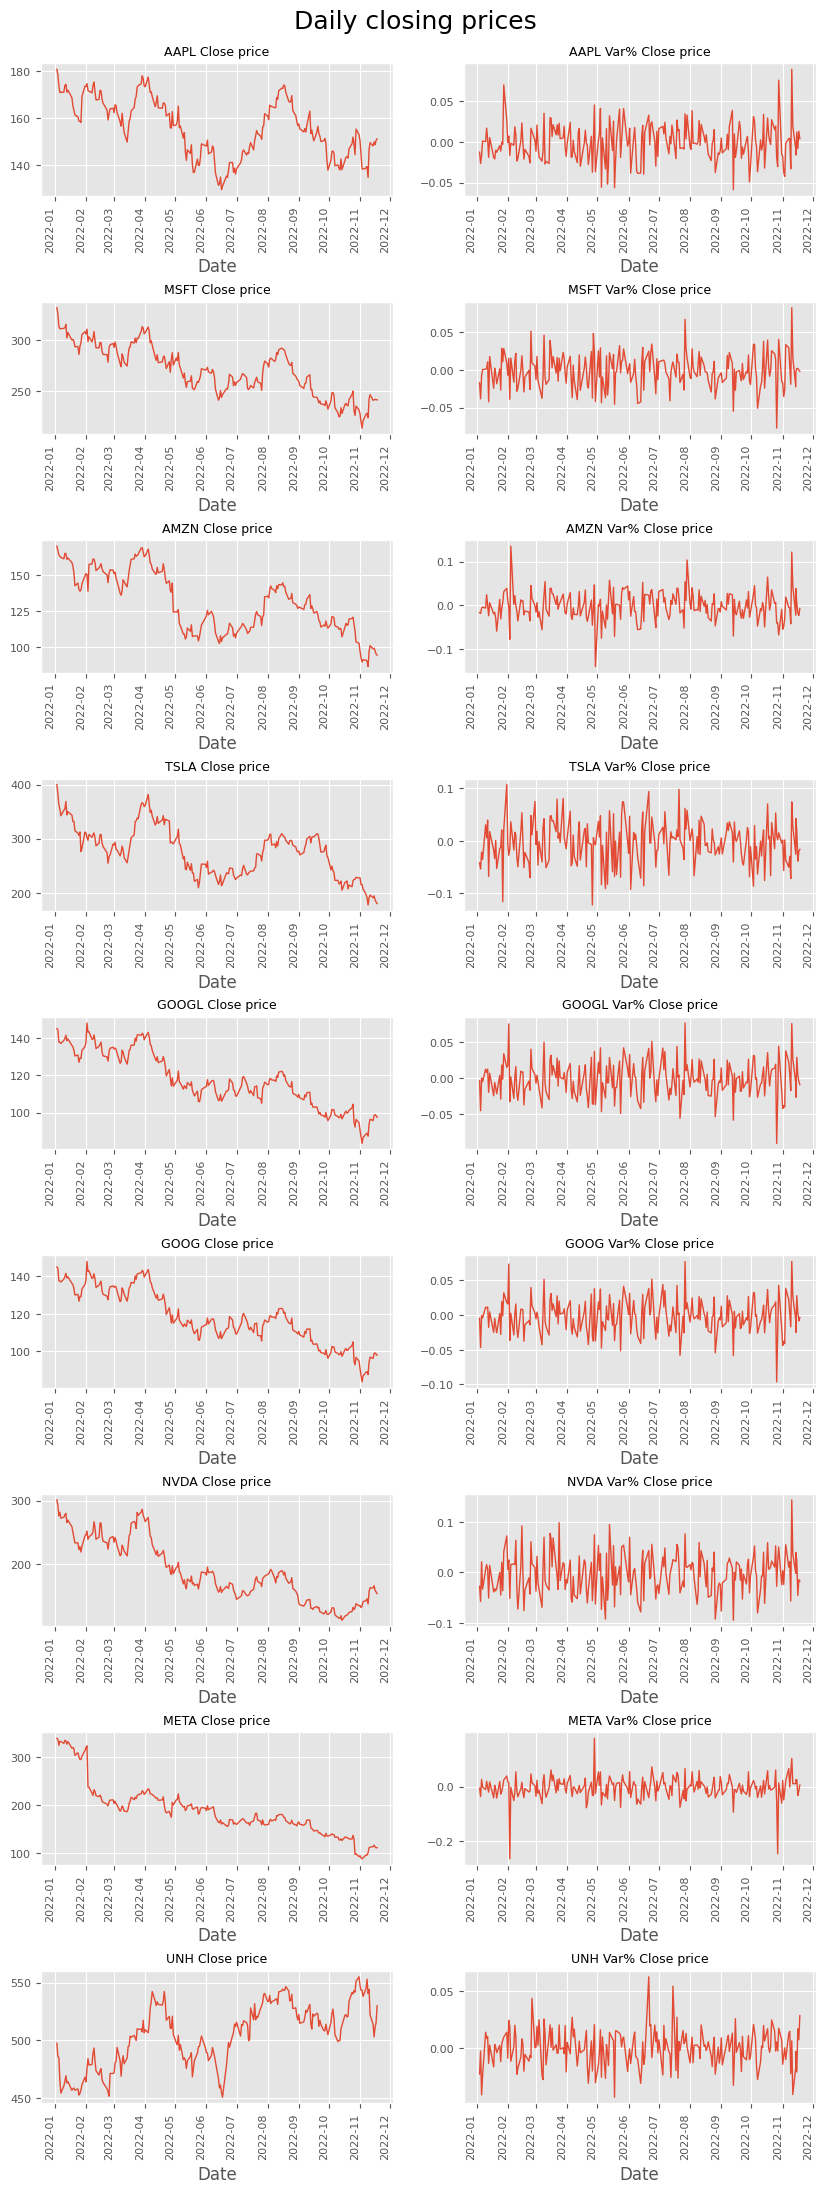

In [76]:
plt.figure(figsize=(10, 30))
plt.subplots_adjust(hspace=0.8)
plt.suptitle("Daily closing prices", fontsize=18, y=0.898)
impar= [1,3,5,7,9,11,13,15,17]
par = [2,4,6,8,10,12,14,16,18]
for i, j in enumerate(data_pct[subconjunto]):
    ax = plt.subplot(9, 2,impar[i])

    data[subconjunto][j].plot(ax=ax, rot=90, fontsize=8, linewidth=1)
    plt.title(f"{j} Close price", fontsize=9)

    ax = plt.subplot(9, 2,par[i])

    data_pct[subconjunto][j].plot(ax=ax, rot=90, fontsize=8,linewidth=1)
    plt.title(f"{j} Var% Close price", fontsize=9)




<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1904e425-e017-401a-bf5a-7f8e011fcf07' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>